In [1]:
%matplotlib inline
from __future__ import division, print_function
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import fitsio
from os.path import expanduser
home = expanduser("~")+'/'
sys.path.append(home+'git/Python/')
import mc_reject, solid_angle
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy import optimize

------------
## Simplest case: a square

In [2]:
rectangle = [-1, 1, -1, 1] # RAmin, RAmax, DECmin, DECmax
# Slightly enlarge the rectangle for randoms
ra_scale = 1/np.cos((rectangle[2]+rectangle[3])/2/180*np.pi)
rectangle_rand = [rectangle[0]-1/60*ra_scale, rectangle[1]+1/60*ra_scale, 
                  rectangle[2]-1/60, rectangle[3]+1/60]
randoms_area = solid_angle.solid_angle(rectangle_rand[0], rectangle_rand[2], rectangle_rand[1], rectangle_rand[3])*(180/np.pi)**2
obj_area = solid_angle.solid_angle(rectangle[0], rectangle[2], rectangle[1], rectangle[3])*(180/np.pi)**2

randoms_density = 4e4
obj_density = 4e4

# Generate randoms with uniform distribution
n_random = int(randoms_density*randoms_area)
ra_random = np.random.uniform(rectangle_rand[0], rectangle_rand[1], n_random)
dec_random = mc_reject.random(np.cos, fmax=1, xmin=rectangle_rand[2]/180*np.pi, 
                              xmax=rectangle_rand[3]/180*np.pi, n=n_random) * 180/np.pi

n_obj = int(obj_density*obj_area)
ra = np.random.uniform(rectangle[0], rectangle[1], n_obj)
dec = mc_reject.random(np.cos, fmax=1, xmin=rectangle[2]/180*np.pi, 
                              xmax=rectangle[3]/180*np.pi, n=n_obj) * 180/np.pi

In [3]:
# Find the shortest distance from each mock to an object
skycat1=SkyCoord(ra*u.degree,dec*u.degree, frame='icrs')
skycat2=SkyCoord(ra_random*u.degree,dec_random*u.degree, frame='icrs')
_, d2d, _ = skycat2.match_to_catalog_sky(skycat1)
# This find a match for each object in skycat2. Not all objects in cat1 catalog is included in the result. 

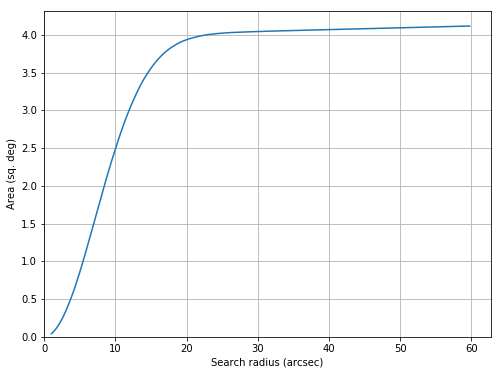

In [4]:
# search radius in arcsec
search_radius_list = np.arange(1., 60, 0.25)
cat_area_list = np.zeros_like(search_radius_list)

for index, search_radius in enumerate(search_radius_list):
    mask = d2d<(search_radius*u.arcsec)
    cat_area = np.sum(mask)/n_random*randoms_area
    cat_area_list[index] = cat_area
    
plt.figure(figsize=(8, 6))
plt.plot(search_radius_list, cat_area_list)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Search radius (arcsec)')
plt.ylabel('Area (sq. deg)')
plt.grid()
plt.show()

In [5]:
def n_match(r, area, lb, n_tot, randoms_density):
    '''
    r: search radius in arcsec
    area: area covered by objects in sq. deg
    lb: fitting parameter
    randoms_density: density of the randoms (per sq. deg)
    '''
    
    # Convert search radius to deg
    r = r/3600.
    return randoms_density*((1-np.exp(-n_tot/area*np.pi*r**2))*(area-lb*r+4*r**2) + \
                      (1-np.exp(-1/2*n_tot/area*np.pi*r**2))*(2*lb*r))

area = 4.0014;  lb = 5.0058
circumference factor = 0.63


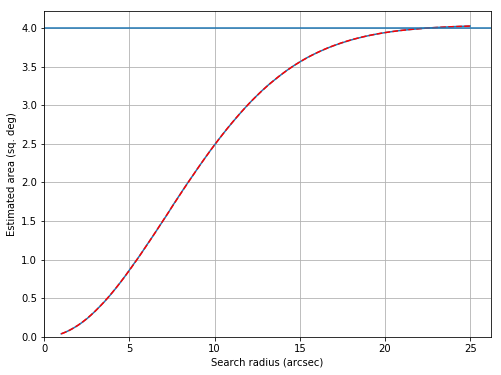

In [6]:
n_tot = n_obj
def n_match1(r, area, lb):
    return n_match(r, area, lb, n_tot, randoms_density)

x = search_radius_list[search_radius_list<=25]
y = cat_area_list[search_radius_list<=25]
popt, pcov = optimize.curve_fit(n_match1, x, y*n_random/randoms_area)
area = popt[0]
lb = popt[1]

print('area = {:.4f};  lb = {:.4f}'.format(area, lb))
# This factor should be 1 for a perfect square:
print('circumference factor = {:.2f}'.format(lb/(4*np.sqrt(area))))
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.plot(x, n_match1(x, area, lb)/n_random*randoms_area, 'r--')
plt.axhline(area)
plt.xlabel('Search radius (arcsec)')
plt.ylabel('Estimated area (sq. deg)')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.grid()
plt.show()

The area estimate is very accurate, although the fractional error in lb is rather large. That's simply because that in this simple case, lb is so small that total area is insensitive to it. 

---------
## DECaLS

In [2]:
rectangle = [130, 135, 23, 28] # RAmin, RAmax, DECmin, DECmax
# Slightly enlarge the rectangle for randoms
ra_scale = 1/np.cos((rectangle[2]+rectangle[3])/2/180*np.pi)
rectangle_rand = [rectangle[0]-1/60*ra_scale, rectangle[1]+1/60*ra_scale, 
                  rectangle[2]-1/60, rectangle[3]+1/60]

data_dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr3/sweep/3.1/'
filelist = ['sweep-130p020-140p025.fits', 'sweep-130p025-140p030.fits']
for index, file_path in enumerate(filelist):
    print(file_path)
    if index==0:
        cat = fitsio.read(os.path.join(data_dir, file_path) , columns=['RA', 'DEC', 'DECAM_NOBS'])
        print(len(cat))
    else:
        cat0 = fitsio.read(os.path.join(data_dir, file_path) , columns=['RA', 'DEC', 'DECAM_NOBS'])
        print(len(cat0))
        cat = np.concatenate([cat, cat0])

print(len(cat))
mask = (cat['RA']>rectangle[0]) & (cat['RA']<rectangle[1]) & \
       (cat['DEC']>rectangle[2]) & (cat['DEC']<rectangle[3])
cat = cat[mask]
print(len(cat))

ra = np.array(cat['RA'])
dec = np.array(cat['DEC'])
nobs = np.array(cat['DECAM_NOBS'])
nobs_total = np.sum(nobs, axis=1)

sweep-130p020-140p025.fits
2315046
sweep-130p025-140p030.fits
1967227
4282273
1194801


In [3]:
# print(len(cat))
# mask = (nobs[:, 1]>=2) & (nobs[:, 2]>=2) & (nobs[:, 4]>=2)
# print(np.sum(mask))
# mask = (nobs[:, 1]>=3) & (nobs[:, 2]>=3) & (nobs[:, 4]>=3)
# print(np.sum(mask))
# print('g visits: ',np.mean(nobs[:, 1]))
# print('r visits: ',np.mean(nobs[:, 2]))
# print('z visits: ',np.mean(nobs[:, 4]))

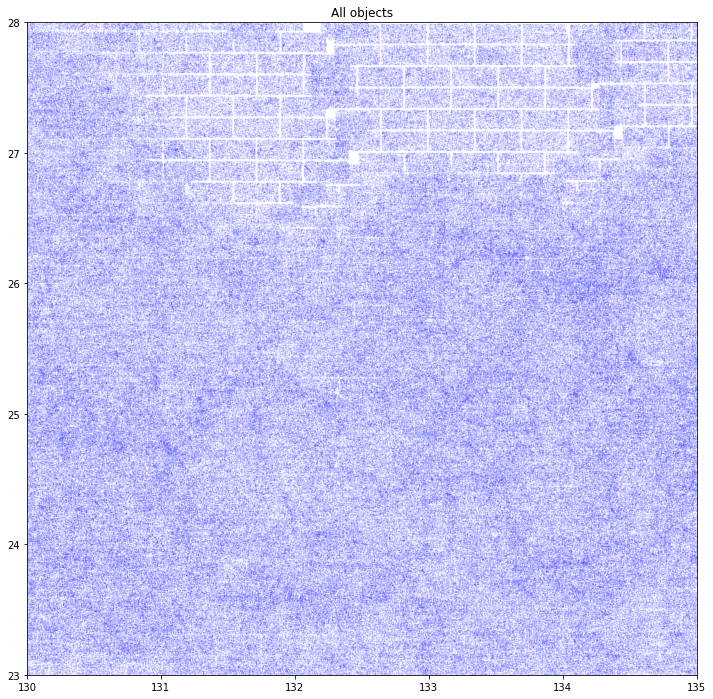

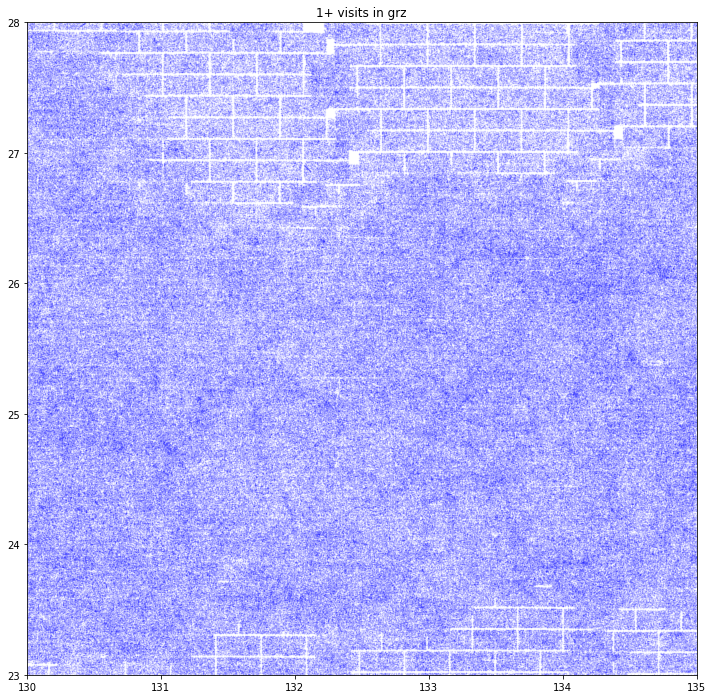

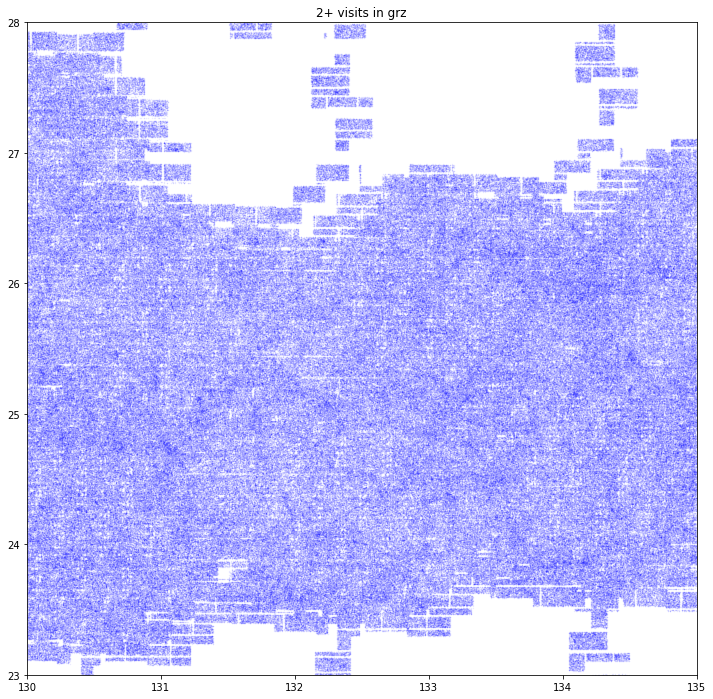

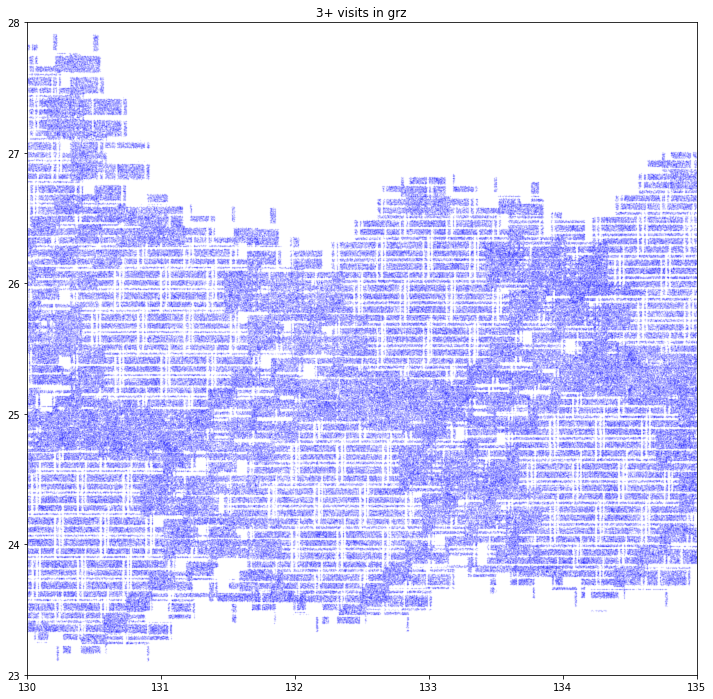

In [5]:
plt.figure(figsize=(12,12))
plt.plot(ra, dec, 'b.', markersize=0.5, alpha=0.1)
plt.title('All objects')
plt.axis(rectangle)

mask_nobs = (nobs[:, 1]>=1) & (nobs[:, 2]>=1) & (nobs[:, 4]>=1)
plt.figure(figsize=(12,12))
plt.plot(ra[mask_nobs], dec[mask_nobs], 'b.', markersize=0.7, alpha=0.1)
plt.title('1+ visits in grz')
plt.axis(rectangle)

mask_nobs = (nobs[:, 1]>=2) & (nobs[:, 2]>=2) & (nobs[:, 4]>=2)
plt.figure(figsize=(12,12))
plt.plot(ra[mask_nobs], dec[mask_nobs], 'b.', markersize=0.7, alpha=0.1)
plt.title('2+ visits in grz')
plt.axis(rectangle)

mask_nobs = (nobs[:, 1]>=3) & (nobs[:, 2]>=3) & (nobs[:, 4]>=3)
plt.figure(figsize=(12,12))
plt.plot(ra[mask_nobs], dec[mask_nobs], 'b.', markersize=0.7, alpha=0.1)
plt.title('3+ visits in grz')
plt.axis(rectangle)
plt.show()

Generate randoms and find the shortest distance to a DECaLS object with >=3 visits. 

In [20]:
randoms_area = solid_angle.solid_angle(rectangle_rand[0], rectangle_rand[2], rectangle_rand[1], rectangle_rand[3])*(180/np.pi)**2
randoms_density = 4e4
print('Area covered by randoms (sq. deg) = {}'.format(randoms_area))
print('Number density of the randoms (per sq. deg) = {}'.format(randoms_density))

# Generate randoms with uniform distribution
n_random = int(randoms_density*randoms_area)
ra_random = np.random.uniform(rectangle_rand[0], rectangle_rand[1], n_random)
dec_random = mc_reject.random(np.cos, fmax=1, xmin=rectangle_rand[2]/180*np.pi, 
                              xmax=rectangle_rand[3]/180*np.pi, n=n_random) * 180/np.pi

Area covered by randoms (sq. deg) = 22.875483391742122
Number density of the randoms (per sq. deg) = 40000.0


In [21]:
# Find the shortest distance to a DECaLS object
mask_nobs = (nobs[:, 1]>=3) & (nobs[:, 2]>=3) & (nobs[:, 4]>=3)
skycat1=SkyCoord(ra[mask_nobs]*u.degree,dec[mask_nobs]*u.degree, frame='icrs')
skycat2=SkyCoord(ra_random*u.degree,dec_random*u.degree, frame='icrs')
_, d2d, _ = skycat2.match_to_catalog_sky(skycat1)
# This find a match for each object in skycat2. Not all objects in cat1 catalog is included in the result. 

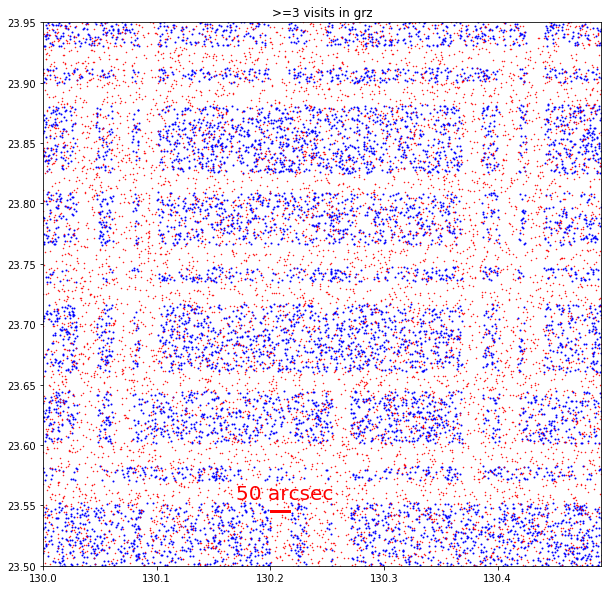

In [22]:
mask_nobs = (nobs[:, 1]>=3) & (nobs[:, 2]>=3) & (nobs[:, 4]>=3)
plt.figure(figsize=(10,10))
plt.plot(ra[mask_nobs], dec[mask_nobs], 'b.', markersize=2, alpha=1, label='DECaLS')
plt.plot(ra_random, dec_random, 'r.', markersize=1, alpha=1, label='Randoms')
plt.title('3+ visits in grz')
plt.axis([130, 130+0.45/np.cos(23.56/180*np.pi), 23.5, 23.95])
plt.plot([130.201, 130.201+(50/3600)/np.cos(23.56/180*np.pi)], [23.545, 23.545], 'r', linewidth=3)
plt.text(130.17, 23.555, '50 arcsec', fontsize=20, color='r')
# plt.legend()
plt.show()

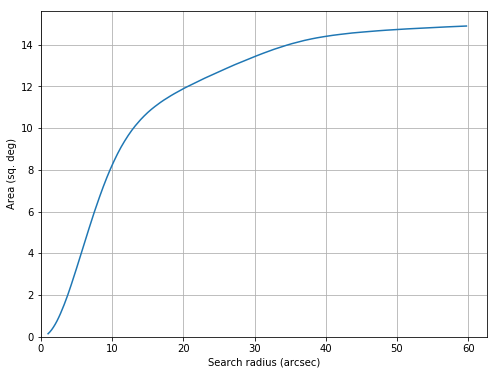

In [23]:
# search radius in arcsec
search_radius_list = np.arange(1., 60, 0.25)
cat_area_list = np.zeros_like(search_radius_list)

for index, search_radius in enumerate(search_radius_list):
    mask = d2d<(search_radius*u.arcsec)
    cat_area = np.sum(mask)/n_random*randoms_area
    cat_area_list[index] = cat_area
    
plt.figure(figsize=(8, 6))
plt.plot(search_radius_list, cat_area_list)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Search radius (arcsec)')
plt.ylabel('Area (sq. deg)')
plt.grid()
plt.show()

## Fit the number of matches vs. search radius relation

In [24]:
def n_match(r, area, lb, n_tot):
    '''
    r: search radius in arcsec
    area: area covered by objects in sq. deg
    lb: fitting parameter
    '''
    
    # Convert search radius to deg
    r = r/3600.
    return randoms_density*((1-np.exp(-n_tot/area*np.pi*r**2))*(area-lb*r+4*r**2) + \
                      (1-np.exp(-1/2*n_tot/area*np.pi*r**2))*(2*lb*r))

The CCD chip gap is ~50" wide. So we should fit with search_radius < 25".

area = 10.13;  lb = 362.49
circumference factor = 28.47
DECaLS number density = 62171.54 per sq deg


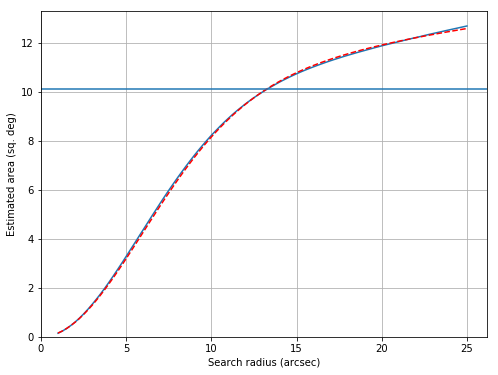

In [25]:
n_tot = np.sum(mask_nobs)
def n_match1(r, area, lb):
    return n_match(r, area, lb, n_tot, randoms_density)

x = search_radius_list[search_radius_list<=25]
y = cat_area_list[search_radius_list<=25]
popt, pcov = optimize.curve_fit(n_match1, x, y*n_random/randoms_area)
area = popt[0]
lb = popt[1]
print('area = {:.2f};  lb = {:.2f}'.format(area, lb))
# This factor should be 1 for a perfect square:
print('circumference factor = {:.2f}'.format(lb/(4*np.sqrt(area))))
print('DECaLS number density = {:.2f} per sq deg'.format(n_tot/area))
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.plot(x, n_match1(x, area, lb)/n_random*randoms_area, 'r--')
plt.axhline(area)
plt.xlabel('Search radius (arcsec)')
plt.ylabel('Estimated area (sq. deg)')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.grid()
plt.show()

## Repeatability in the area estimate

In [26]:
nloops = 20
area_list = np.zeros(nloops)
lb_list = np.zeros(nloops)
search_radius_list = np.arange(1., 30, 0.25)

for loop_index in range(nloops):
    print('\r{}'.format(loop_index), end='')
    cat_area_list = np.zeros_like(search_radius_list)

    # Generate random coordinates with distribution of cos(Dec)
    n_random = int(randoms_density*randoms_area)
    ra_random = np.random.uniform(rectangle_rand[0], rectangle_rand[1], n_random)
    dec_random = mc_reject.random(np.cos, fmax=1, xmin=rectangle_rand[2]/180*np.pi, 
                                  xmax=rectangle_rand[3]/180*np.pi, n=n_random) * 180/np.pi
    
    skycat1=SkyCoord(ra[mask_nobs]*u.degree,dec[mask_nobs]*u.degree, frame='icrs')
    skycat2=SkyCoord(ra_random*u.degree,dec_random*u.degree, frame='icrs')
    _, d2d, _ = skycat2.match_to_catalog_sky(skycat1)
    # This find a match for each object in skycat2. Not all objects in cat1 catalog is included in the result. 

    for index, search_radius in enumerate(search_radius_list):
        mask = d2d<(search_radius*u.arcsec)
        cat_area = np.sum(mask)/n_random*randoms_area
        cat_area_list[index] = cat_area
    
    x = search_radius_list[search_radius_list<=25]
    y = cat_area_list[search_radius_list<=25]
    popt, pcov = optimize.curve_fit(n_match1, x, y*n_random/randoms_area)
    area_list[loop_index] = popt[0]
    lb_list[loop_index] = popt[1]

19

Mean area = .10.135
Standard deviation = 0.028
0.275% variability


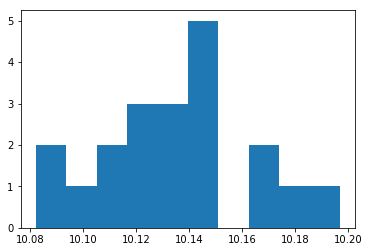

In [27]:
print('Mean area = .{:.3f}'.format(np.mean(area_list)))
print('Standard deviation = {:.3f}'.format(np.std(area_list)))
print('{:.3f}% variability'.format(np.std(area_list)/np.mean(area_list)*100))
plt.hist(area_list)
plt.show()

--------------------
Calculate slope (why?)

In [109]:
# def f(x, a, b):
#     return a*x+b

# x = search_radius_list
# y = cat_area_list
# plt.plot(x, y)

# x = search_radius_list[(search_radius_list>=4)&(search_radius_list<=10)]
# y = cat_area_list[(search_radius_list>=4)&(search_radius_list<=10)]
# popt, pcov = optimize.curve_fit(f, x, y)
# plt.plot(x, f(x, popt[0], popt[1]), 'r--')
# print(popt)

# x = search_radius_list[(search_radius_list>=18)&(search_radius_list<=30)]
# y = cat_area_list[(search_radius_list>=18)&(search_radius_list<=30)]
# popt, pcov = optimize.curve_fit(f, x, y)
# plt.plot(x, f(x, popt[0], popt[1]), 'r--')
# print(popt)

# x = search_radius_list[(search_radius_list>=60)&(search_radius_list<=80)]
# y = cat_area_list[(search_radius_list>=60)&(search_radius_list<=80)]
# popt, pcov = optimize.curve_fit(f, x, y)
# plt.plot(x, f(x, popt[0], popt[1]), 'r--')
# print(popt)

# plt.xlabel('Search radius (arcsec)')
# plt.ylabel('Estimated area (sq. deg)')
# plt.grid()
# plt.show()